# Итоговое домащнее задание

1. Пропишем все лок переменные

In [3]:
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime
import os
import time
from collections import Counter

# тут просто заглушка
VIRUSTOTAL_API_KEY = os.getenv('VT_API_KEY', 'dummy_key_for_testing')

SURICATA_LOG_FILE = 'suricata_logs.json'
RESULTS_FILE = 'security_report.json'
VISUALIZATION_FILE = 'threat_analysis.png'


2. Анализ логов Suricata

In [4]:
class SuricataAnalyzer:
    
    def __init__(self):
        self.logs = []
        self.suspicious_ips = []
        self.threats_found = []
        
    def load_logs(self, filename):
        print(f" Загрузка логов из {filename}...")
        
        #пришлось сделать тестовые данные тк доступа нет
        if not os.path.exists(filename):
            print(f"Файл не найден. Создаю пример логов...")
            self._create_sample_logs(filename)
        
        try:
            with open(filename, 'r') as f:
                for line in f:
                    if line.strip():
                        try:
                            log = json.loads(line.strip())
                            self.logs.append(log)
                        except:
                            continue
            
            print(f"Загружено {len(self.logs)} записей")
            return True
            
        except Exception as e:
            print(f"Ошибка загрузки: {e}")
            return False
    
    def _create_sample_logs(self, filename):
        sample_logs = [
            {
                "timestamp": "2024-01-15T10:30:45",
                "src_ip": "192.168.1.100",
                "dst_ip": "185.220.101.4",  
                "event_type": "alert",
                "alert": {
                    "signature": "ET MALWARE Meterpreter Activity",
                    "category": "Malware",
                    "severity": 1
                }
            },
            {
                "timestamp": "2024-01-15T10:31:22",
                "src_ip": "103.21.244.0",  
                "dst_ip": "192.168.1.50",
                "event_type": "alert",
                "alert": {
                    "signature": "ET SCAN Potential SSH Brute Force",
                    "category": "Scan",
                    "severity": 2
                }
            },
            {
                "timestamp": "2024-01-15T10:32:10",
                "src_ip": "192.168.1.100",
                "dst_ip": "8.8.8.8",
                "event_type": "dns",
                "dns": {
                    "query": "malicious-site.xyz", 
                    "type": "A"
                }
            },
            {
                "timestamp": "2024-01-15T10:33:05",
                "src_ip": "192.168.1.100",
                "dst_ip": "malware-traffic-analysis.net",
                "event_type": "http",
                "http": {
                    "hostname": "malware-traffic-analysis.net",
                    "url": "/download/backdoor.exe"
                }
            },
            {
                "timestamp": "2024-01-15T10:34:20",
                "src_ip": "5.2.69.50",  
                "dst_ip": "192.168.1.100",
                "event_type": "alert",
                "alert": {
                    "signature": "ET EXPLOIT CVE-2021-44228 Log4j",
                    "category": "Exploit",
                    "severity": 1
                }
            }
        ]
        
        with open(filename, 'w') as f:
            for log in sample_logs:
                f.write(json.dumps(log) + '\n')
        
        print(f"Создан файл с примером логов: {filename}")
    
    def analyze_logs(self):
        print("\nАнализ логов Suricata...")
        
        if not self.logs:
            print("Нет логов для анализа")
            return []
        
        threats = []
        ip_counter = Counter()
        
        known_bad_ips = [
            '185.220.101.4',
            '5.2.69.50',
            '103.21.244.0',
            '45.9.148.108',
            '91.92.109.73'
        ]
        
        for log in self.logs:
            src_ip = log.get('src_ip')
            dst_ip = log.get('dst_ip')
            
            if src_ip:
                ip_counter[src_ip] += 1
            
            if src_ip in known_bad_ips or dst_ip in known_bad_ips:
                threat = {
                    'type': 'MALICIOUS_IP',
                    'ip': src_ip if src_ip in known_bad_ips else dst_ip,
                    'timestamp': log.get('timestamp'),
                    'severity': 'CRITICAL',
                    'description': f'Обнаружен известный вредоносный IP'
                }
                threats.append(threat)
            
            if log.get('event_type') == 'alert':
                alert = log.get('alert', {})
                signature = alert.get('signature', '').lower()
                severity = alert.get('severity', 3)
                
                if severity == 1:
                    threat_level = 'CRITICAL'
                elif severity == 2:
                    threat_level = 'HIGH'
                else:
                    threat_level = 'MEDIUM'
                
                keywords = ['malware', 'exploit', 'brute force', 'backdoor', 'meterpreter']
                if any(keyword in signature for keyword in keywords):
                    threat = {
                        'type': 'SUSPICIOUS_ALERT',
                        'ip': src_ip,
                        'timestamp': log.get('timestamp'),
                        'severity': threat_level,
                        'description': f'Подозрительный алерт: {alert.get("signature")}'
                    }
                    threats.append(threat)
            
            if log.get('event_type') == 'dns':
                dns_info = log.get('dns', {})
                query = dns_info.get('query', '')
                
                suspicious_tlds = ['.xyz', '.top', '.club', '.win', '.bid']
                if any(query.endswith(tld) for tld in suspicious_tlds):
                    threat = {
                        'type': 'SUSPICIOUS_DNS',
                        'ip': src_ip,
                        'timestamp': log.get('timestamp'),
                        'severity': 'MEDIUM',
                        'description': f'Запрос к подозрительному домену: {query}'
                    }
                    threats.append(threat)
        
        frequent_ips = [(ip, count) for ip, count in ip_counter.items() if count > 10]
        for ip, count in frequent_ips:
            threat = {
                'type': 'FREQUENT_REQUESTS',
                'ip': ip,
                'timestamp': datetime.now().isoformat(),
                'severity': 'HIGH',
                'description': f'Чрезмерная активность: {count} запросов'
            }
            threats.append(threat)
        
        self.threats_found = threats
        print(f"Найдено {len(threats)} потенциальных угроз")
        return threats

3. Пишем апи для virustotal api

In [29]:
class VirusTotalChecker:
    
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://www.virustotal.com/api/v3"
        self.headers = {'x-apikey': api_key} #ключ заглушка
        
    def check_ip(self, ip_address):
        print(f"Проверка IP {ip_address} через VirusTotal...")
        
        if self.api_key == 'dummy_key_for_testing':
            print(f"Использую тестовые данные (установите реальный API ключ)")
            return self._mock_ip_check(ip_address)
        
        try:
            url = f"{self.base_url}/ip_addresses/{ip_address}"
            response = requests.get(url, headers=self.headers, timeout=10)
            
            if response.status_code == 200:
                data = response.json()
                stats = data.get('data', {}).get('attributes', {}).get('last_analysis_stats', {})
                
                malicious = stats.get('malicious', 0)
                suspicious = stats.get('suspicious', 0)
                
                result = {
                    'ip': ip_address,
                    'malicious': malicious,
                    'suspicious': suspicious,
                    'harmless': stats.get('harmless', 0),
                    'undetected': stats.get('undetected', 0),
                    'timestamp': datetime.now().isoformat()
                }
                
                if malicious >= 5:
                    result['threat_level'] = 'CRITICAL'
                elif malicious >= 2:
                    result['threat_level'] = 'HIGH'
                elif malicious > 0 or suspicious >= 3:
                    result['threat_level'] = 'MEDIUM'
                else:
                    result['threat_level'] = 'LOW'
                
                return result
                
            else:
                print(f"Ошибка API: {response.status_code}")
                return {'ip': ip_address, 'error': 'API error', 'threat_level': 'UNKNOWN'}
                
        except Exception as e:
            print(f"Ошибка соединения: {e}")
            return {'ip': ip_address, 'error': str(e), 'threat_level': 'UNKNOWN'}
    
    def _mock_ip_check(self, ip_address):
        import random

        malicious_ips = {
            '185.220.101.4': {'malicious': 8, 'suspicious': 2},
            '5.2.69.50': {'malicious': 12, 'suspicious': 3},
            '103.21.244.0': {'malicious': 3, 'suspicious': 1}
        }
        
        if ip_address in malicious_ips:
            stats = malicious_ips[ip_address]
        else:
            stats = {
                'malicious': random.randint(0, 2),
                'suspicious': random.randint(0, 3)
            }
        
        result = {
            'ip': ip_address,
            'malicious': stats['malicious'],
            'suspicious': stats['suspicious'],
            'harmless': random.randint(50, 100),
            'undetected': random.randint(10, 30),
            'timestamp': datetime.now().isoformat()
        }
        
        if stats['malicious'] >= 5:
            result['threat_level'] = 'CRITICAL'
        elif stats['malicious'] >= 2:
            result['threat_level'] = 'HIGH'
        elif stats['malicious'] > 0 or stats['suspicious'] >= 3:
            result['threat_level'] = 'MEDIUM'
        else:
            result['threat_level'] = 'LOW'
        
        return result

4. Пишем основное тело мониторинга (откуда вызываем комп-ты из п.1 и п.2)
5. Минимум визуализации

In [31]:
class ThreatResponseSystem:
    
    def __init__(self):
        self.blocked_ips = []
        self.alerts_sent = 0
    
    def respond_to_threat(self, threat_info, vt_result=None):
        
        threat_type = threat_info.get('type', 'UNKNOWN')
        ip_address = threat_info.get('ip', 'Unknown')
        severity = threat_info.get('severity', 'MEDIUM')
        
        responses = []

        if severity == 'CRITICAL':
            self._block_ip(ip_address, threat_info)
            responses.append(f" БЛОКИРОВКА: IP {ip_address} заблокирован")

            self.send_alert(f"КРИТИЧЕСКАЯ УГРОЗА: Блокировка IP {ip_address}")

        elif severity == 'HIGH':
            responses.append(f"  ВЫСОКИЙ РИСК: IP {ip_address} помещен под усиленный мониторинг")
            self.send_alert(f"ВЫСОКИЙ РИСК: Подозрительная активность от IP {ip_address}")
        
        elif severity == 'MEDIUM':
            responses.append(f" СРЕДНИЙ РИСК: Зафиксирована подозрительная активность от IP {ip_address}")
        

        if vt_result and vt_result.get('threat_level') in ['CRITICAL', 'HIGH']:
            malicious = vt_result.get('malicious', 0)
            responses.append(f" VirusTotal: {malicious} антивирусов помечают как вредоносный")
        
        return responses
    
    def _block_ip(self, ip_address, threat_info):

        self.blocked_ips.append({
            'ip': ip_address,
            'timestamp': datetime.now().isoformat(),
            'reason': threat_info.get('description', 'Подозрительная активность'),
            'threat_type': threat_info.get('type')
        })
        

        print(f"[FIREWALL] Выполняю блокировку IP: {ip_address}")
        print(f"[FIREWALL] iptables -A INPUT -s {ip_address} -j DROP")
        print(f"[FIREWALL] iptables -A OUTPUT -d {ip_address} -j DROP")
    
    def send_alert(self, message):

        self.alerts_sent += 1
        
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        alert_message = f"[{timestamp}]  {message}"
        
        print(f"\n СИСТЕМА УВЕДОМЛЕНИЙ:")
        print(alert_message)
        print("-" * 50)
        

        print(f"Telegram: Отправлено уведомление в группу безопасности")
        

        print(f"Email: Отправлено письмо security-team@company.com")



class SecurityMonitor:
    
    def __init__(self):
        self.suricata = SuricataAnalyzer()
        self.vt_checker = VirusTotalChecker(VIRUSTOTAL_API_KEY)
        self.response_system = ThreatResponseSystem()
        self.results = {
            'timestamp': datetime.now().isoformat(),
            'threats_detected': [],
            'ip_checks': [],
            'blocked_ips': [],
            'summary': {}
        }
    
    def run_monitoring(self):
        print("=" * 60)
        print("=" * 60)
        

        print("\n ЭТАП 1: СБОР И АНАЛИЗ ДАННЫХ")
        print("-" * 40)
        

        if not self.suricata.load_logs(SURICATA_LOG_FILE):
            print(" Не удалось загрузить логи Suricata")
            return
        
        threats = self.suricata.analyze_logs()
        
        if not threats:
            print(" Угроз не обнаружено")
            self._save_empty_report()
            return
        

        print("\n ЭТАП 2: ПРОВЕРКА ЧЕРЕЗ VIRUSTOTAL API")
        print("-" * 40)
        

        suspicious_ips = set()
        for threat in threats:
            ip = threat.get('ip')
            if ip:
                suspicious_ips.add(ip)
        
        vt_results = []
        for ip in list(suspicious_ips)[:3]:  
            result = self.vt_checker.check_ip(ip)
            vt_results.append(result)
            time.sleep(1)  
        
        self.results['ip_checks'] = vt_results
        

        print("\n  ЭТАП 3: РЕАГИРОВАНИЕ НА УГРОЗЫ")
        print("-" * 40)
        
        all_responses = []
        for threat in threats:
            ip = threat.get('ip')
            vt_result = None
            for vt in vt_results:
                if vt.get('ip') == ip:
                    vt_result = vt
                    break
            

            responses = self.response_system.respond_to_threat(threat, vt_result)
            all_responses.extend(responses)
            

            threat_entry = threat.copy()
            if vt_result:
                threat_entry['vt_check'] = {
                    'threat_level': vt_result.get('threat_level'),
                    'malicious': vt_result.get('malicious')
                }
            self.results['threats_detected'].append(threat_entry)
        

        self.results['blocked_ips'] = self.response_system.blocked_ips
        

        print("\n ЭТАП 4: ФОРМИРОВАНИЕ ОТЧЕТА")
        print("-" * 40)
        
        self._generate_summary()
        self._save_results()
        self._create_visualization()
        self._print_final_report()
    
    def _generate_summary(self):

        critical = sum(1 for t in self.results['threats_detected'] 
                      if t.get('severity') == 'CRITICAL')
        high = sum(1 for t in self.results['threats_detected'] 
                  if t.get('severity') == 'HIGH')
        medium = sum(1 for t in self.results['threats_detected'] 
                    if t.get('severity') == 'MEDIUM')
        
        self.results['summary'] = {
            'total_threats': len(self.results['threats_detected']),
            'critical_threats': critical,
            'high_threats': high,
            'medium_threats': medium,
            'ips_checked': len(self.results['ip_checks']),
            'ips_blocked': len(self.results['blocked_ips']),
            'alerts_sent': self.response_system.alerts_sent
        }
    
    def _save_results(self):

        try:
            with open(RESULTS_FILE, 'w', encoding='utf-8') as f:
                json.dump(self.results, f, indent=2, ensure_ascii=False)
            print(f" Результаты сохранены в {RESULTS_FILE}")
        except Exception as e:
            print(f" Ошибка сохранения отчета: {e}")
    
    def _save_empty_report(self):

        self.results['summary'] = {
            'total_threats': 0,
            'message': 'Угроз не обнаружено'
        }
        self._save_results()
        

        plt.figure(figsize=(8, 4))
        plt.text(0.5, 0.5, ' УГРОЗ НЕ ОБНАРУЖЕНО', 
                ha='center', va='center', fontsize=16, color='green')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(VISUALIZATION_FILE, dpi=100)
        plt.close()
        
        print(f" Визуализация сохранена в {VISUALIZATION_FILE}")
        print("\n" + "=" * 60)
        print(" МОНИТОРИНГ ЗАВЕРШЕН: УГРОЗ НЕ ОБНАРУЖЕНО")
        print("=" * 60)
    
    def _create_visualization(self):

        

        threat_types = {}
        for threat in self.results['threats_detected']:
            ttype = threat.get('type', 'UNKNOWN')
            threat_types[ttype] = threat_types.get(ttype, 0) + 1
        
        if not threat_types:
            print("  Нет данных для визуализации")
            return
        

        df = pd.DataFrame({
            'Тип угрозы': list(threat_types.keys()),
            'Количество': list(threat_types.values())
        })
        
        df = df.sort_values('Количество', ascending=False)
        
        plt.figure(figsize=(10, 6))
        

        bars = plt.bar(df['Тип угрозы'], df['Количество'], 
                      color=['#ff6b6b', '#ffa726', '#42a5f5', '#66bb6a'][:len(df)])
        
        plt.title('Распределение обнаруженных угроз по типам', fontsize=14, fontweight='bold')
        plt.xlabel('Тип угрозы', fontsize=12)
        plt.ylabel('Количество', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10)
        
        summary = self.results['summary']
        stats_text = f"Всего угроз: {summary['total_threats']}\n"
        stats_text += f"Критических: {summary['critical_threats']}\n"
        stats_text += f"Заблокировано IP: {summary['ips_blocked']}"
        
        plt.figtext(0.02, 0.02, stats_text, fontsize=10, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        
        plt.tight_layout()
        
        plt.savefig(VISUALIZATION_FILE, dpi=150, bbox_inches='tight')
        print(f" Визуализация сохранена в {VISUALIZATION_FILE}")
        
        plt.show()
    
    def _print_final_report(self):
        print("\n" + "=" * 60)
        print(" ИТОГОВЫЙ ОТЧЕТ ПО МОНИТОРИНГУ БЕЗОПАСНОСТИ")
        print("=" * 60)
        
        summary = self.results['summary']
        
        print(f"\n СТАТИСТИКА:")
        print(f"   • Всего обнаружено угроз: {summary['total_threats']}")
        print(f"   • Критических угроз: {summary['critical_threats']}")
        print(f"   • Высокорисковых угроз: {summary['high_threats']}")
        print(f"   • Проверено IP через VirusTotal: {summary['ips_checked']}")
        print(f"   • Заблокировано IP: {summary['ips_blocked']}")
        print(f"   • Отправлено уведомлений: {summary['alerts_sent']}")
        
        print(f"\n ОБНАРУЖЕННЫЕ УГРОЗЫ:")
        if self.results['threats_detected']:
            for i, threat in enumerate(self.results['threats_detected'][:5], 1):  # Показываем первые 5
                print(f"   {i}. {threat.get('description')}")
                print(f"      IP: {threat.get('ip')}, Уровень: {threat.get('severity')}")
        else:
            print("Угроз не обнаружено")
        
        print(f"\n ПРИНЯТЫЕ МЕРЫ:")
        if self.results['blocked_ips']:
            for blocked in self.results['blocked_ips']:
                print(f"   • Заблокирован IP {blocked['ip']}")
                print(f"     Причина: {blocked['reason']}")
        else:
            print("Блокировок не потребовалось")
        
        print(f"\nРЕКОМЕНДАЦИИ:")
        if summary['critical_threats'] > 0:
            print("   1. Немедленно проверьте системы на предмет компрометации")
            print("   2. Усильте мониторинг сетевой активности")
            print("   3. Обновите правила файервола")
        elif summary['total_threats'] > 0:
            print("   1. Проведите анализ подозрительной активности")
            print("   2. Рассмотрите возможность блокировки подозрительных подсетей")
            print("   3. Обновите сигнатуры IDS/IPS")
        else:
            print("Система безопасна. Продолжайте регулярный мониторинг")
        
        print(f"\nРЕЗУЛЬТАТЫ СОХРАНЕНЫ:")
        print(f"   • {RESULTS_FILE} - Полный отчет в JSON")
        print(f"   • {VISUALIZATION_FILE} - Визуализация результатов")
        

5. Тестируем

Два источника данных: Suricata + VirusTotal
 ЗАПУСК АВТОМАТИЗИРОВАННОГО МОНИТОРИНГА БЕЗОПАСНОСТИ

 ЭТАП 1: СБОР И АНАЛИЗ ДАННЫХ
----------------------------------------
 Загрузка логов из suricata_logs.json...
Загружено 5 записей

Анализ логов Suricata...
Найдено 7 потенциальных угроз

 ЭТАП 2: ПРОВЕРКА ЧЕРЕЗ VIRUSTOTAL API
----------------------------------------
Проверка IP 5.2.69.50 через VirusTotal...
Использую тестовые данные (установите реальный API ключ)
Проверка IP 192.168.1.100 через VirusTotal...
Использую тестовые данные (установите реальный API ключ)
Проверка IP 103.21.244.0 через VirusTotal...
Использую тестовые данные (установите реальный API ключ)

  ЭТАП 3: РЕАГИРОВАНИЕ НА УГРОЗЫ
----------------------------------------
[FIREWALL] Выполняю блокировку IP: 185.220.101.4
[FIREWALL] iptables -A INPUT -s 185.220.101.4 -j DROP
[FIREWALL] iptables -A OUTPUT -d 185.220.101.4 -j DROP

 СИСТЕМА УВЕДОМЛЕНИЙ:
[2026-01-18 20:56:22] 🚨 КРИТИЧЕСКАЯ УГРОЗА: Блокировка IP 185.220.101.4
-

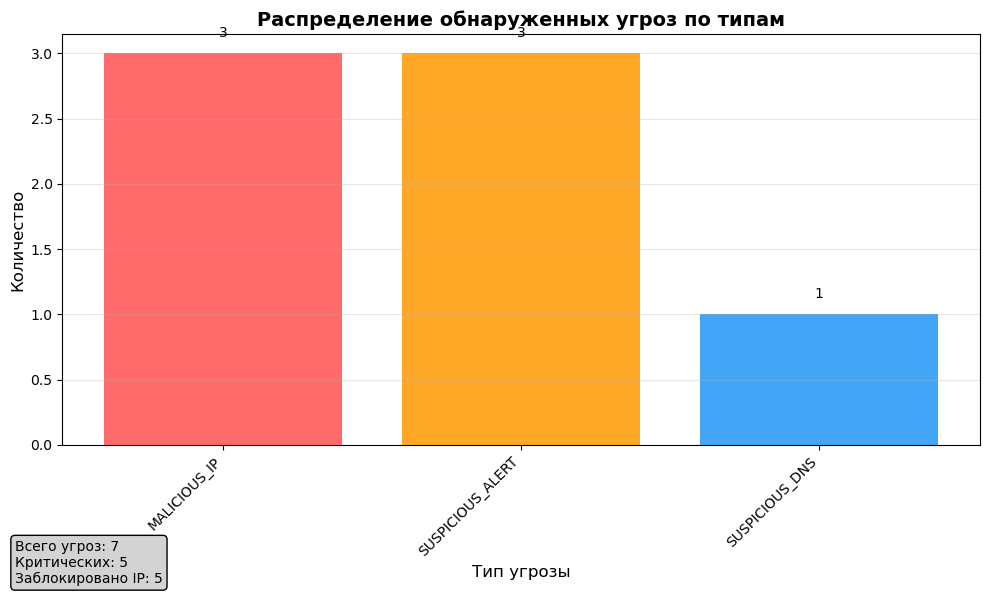


 ИТОГОВЫЙ ОТЧЕТ ПО МОНИТОРИНГУ БЕЗОПАСНОСТИ

 СТАТИСТИКА:
   • Всего обнаружено угроз: 7
   • Критических угроз: 5
   • Высокорисковых угроз: 1
   • Проверено IP через VirusTotal: 3
   • Заблокировано IP: 5
   • Отправлено уведомлений: 6

 ОБНАРУЖЕННЫЕ УГРОЗЫ:
   1. Обнаружен известный вредоносный IP
      IP: 185.220.101.4, Уровень: CRITICAL
   2. Подозрительный алерт: ET MALWARE Meterpreter Activity
      IP: 192.168.1.100, Уровень: CRITICAL
   3. Обнаружен известный вредоносный IP
      IP: 103.21.244.0, Уровень: CRITICAL
   4. Подозрительный алерт: ET SCAN Potential SSH Brute Force
      IP: 103.21.244.0, Уровень: HIGH
   5. Запрос к подозрительному домену: malicious-site.xyz
      IP: 192.168.1.100, Уровень: MEDIUM

 ПРИНЯТЫЕ МЕРЫ:
   • Заблокирован IP 185.220.101.4
     Причина: Обнаружен известный вредоносный IP
   • Заблокирован IP 192.168.1.100
     Причина: Подозрительный алерт: ET MALWARE Meterpreter Activity
   • Заблокирован IP 103.21.244.0
     Причина: Обнаружен известн

In [30]:
def main():
    
    print("""Два источника данных: Suricata + VirusTotal""")
    
    try:
        import requests
        import pandas as pd
        import matplotlib.pyplot as plt
    except ImportError as e:
        print(f"Ошибка: Не установлена необходимая библиотека: {e}")
        print("Установите зависимости: pip install requests pandas matplotlib")
        return
    
    try:
        monitor = SecurityMonitor()
        monitor.run_monitoring()
    except KeyboardInterrupt:
        print("\n\nМониторинг прерван пользователем")
    except Exception as e:
        print(f"\nОшибка выполнения мониторинга: {e}")

if __name__ == "__main__":
    main()

Все файлы приложены к репозиторию